## 1. Setup & Imports

We begin by loading the Titanic dataset and getting a high-level overview.

In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Models
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


# Metrics
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')


SEED = 42
np.random.seed(SEED)

## 2. Load Data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
gender_sub = pd.read_csv('gender_submission.csv')


print(train.shape, test.shape)
train.head()

(891, 12) (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2. Feature Engineering

Feature engineering is the process of creating new, more informative features from the existing data. This is often the most impactful part of a machine learning project. We apply these transformations to both the training and test sets to ensure consistency.


In [3]:
# --- Feature Engineering ---

# Extract Title from Name
def extract_title(name):
    if pd.isna(name):
        return 'Unknown'
    return name.split(',')[1].split('.')[0].strip()

# Extract Ticket Prefix
def extract_ticket_prefix(ticket):
    ticket = ticket.replace('.', '').replace('/', '').split()
    return ticket[0] if not ticket[0].isdigit() else 'NONE'

# Apply transformations to both train and test
for df in [train, test]:
    df['Title'] = df['Name'].apply(extract_title)
    df['Title'] = df['Title'].replace(
        ['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'],
        'Rare'
    )
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    df['CabinDeck'] = df['Cabin'].str[0].fillna('U')
    df['HasCabin'] = (~df['Cabin'].isnull()).astype(int)
    df['TicketPrefix'] = df['Ticket'].apply(extract_ticket_prefix)
    df['Fare'].fillna(df['Fare'].median(), inplace=True)
    df['Fare_log'] = np.log1p(df['Fare'])

# --- Age Imputation by Title ---
age_medians = train.groupby('Title')['Age'].median()
for df in [train, test]:
    df['Age'] = df.apply(lambda r: age_medians[r['Title']] if pd.isna(r['Age']) else r['Age'], axis=1)

# --- Fill Embarked missing values with mode ---
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)


## 3. Prepare Data for Modeling

In [4]:
# --- Feature Selection ---
features = [
    'Pclass', 'Sex', 'Age', 'Fare_log', 'Embarked', 'Title',
    'FamilySize', 'IsAlone', 'HasCabin', 'CabinDeck', 'TicketPrefix'
]

X = train[features].copy()
y = train['Survived']
X_test = test[features].copy()

# --- Encode categorical features ---
for col in ['Sex', 'Embarked', 'Title', 'CabinDeck', 'TicketPrefix']:
    X[col] = X[col].astype(str)
    X_test[col] = X_test[col].astype(str)

X = pd.get_dummies(X, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Align columns (test set may have missing or extra dummy variables)
X_test = X_test.reindex(columns=X.columns, fill_value=0)

# --- Scale numeric columns ---
from sklearn.preprocessing import StandardScaler

num_cols = ['Age', 'Fare_log', 'FamilySize']
scaler = StandardScaler()

X[num_cols] = scaler.fit_transform(X[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

print("✅ Preprocessing complete!")
print("Train shape:", X.shape)
print("Test shape:", X_test.shape)


✅ Preprocessing complete!
Train shape: (891, 55)
Test shape: (418, 55)


## 4. Model Training & Tuning

In [5]:
# Random Forest
rf = RandomForestClassifier(random_state=SEED)
rf_params = {
'n_estimators': [200, 400, 600],
'max_depth': [4, 6, 8, None],
'min_samples_split': [2, 5, 10],
'min_samples_leaf': [1, 2, 4],
'max_features': ['sqrt', 'log2']
}
rf_search = RandomizedSearchCV(rf, rf_params, cv=5, n_iter=25, scoring='accuracy', n_jobs=-1, random_state=SEED)
rf_search.fit(X, y)
rf_best = rf_search.best_estimator_


# XGBoost
xgb = XGBClassifier(
random_state=SEED, use_label_encoder=False, eval_metric='logloss')
xgb_params = {
'n_estimators': [200, 400],
'learning_rate': [0.03, 0.05, 0.1],
'max_depth': [3, 4, 5],
'subsample': [0.8, 1.0],
'colsample_bytree': [0.8, 1.0]
}
xgb_search = RandomizedSearchCV(xgb, xgb_params, cv=5, n_iter=20, scoring='accuracy', n_jobs=-1, random_state=SEED)
xgb_search.fit(X, y)
xgb_best = xgb_search.best_estimator_

## 5. Ensemble (Soft Voting)


In [6]:
log = LogisticRegression(random_state=SEED, max_iter=1000)
voting = VotingClassifier(estimators=[('rf', rf_best), ('xgb', xgb_best), ('log', log)], voting='soft')


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
scores = cross_val_score(voting, X, y, cv=cv, scoring='accuracy')
print('VotingClassifier CV Accuracy:', scores.mean(), '+/-', scores.std())


voting.fit(X, y)

VotingClassifier CV Accuracy: 0.8406126420187057 +/- 0.014631371861025937


,estimators,"[('rf', ...), ('xgb', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,n_estimators,200
,criterion,'gini'
,max_depth,8
,min_samples_split,5
,min_samples_leaf,1


## 6. Feature Importance (XGBoost)

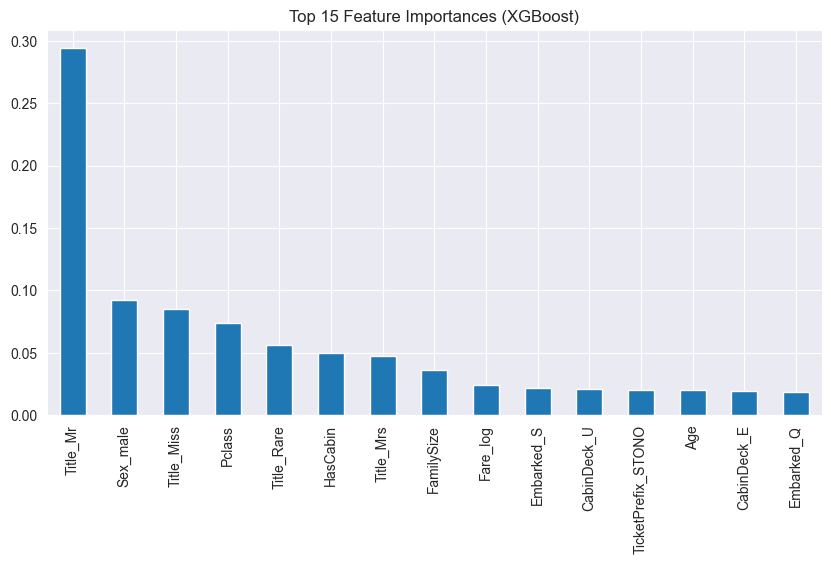

In [7]:
importances = pd.Series(xgb_best.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,5))
importances.head(15).plot(kind='bar')
plt.title('Top 15 Feature Importances (XGBoost)')
plt.show()

## 8. Predictions & Submission

Finally, we fit our optimized ensemble on the **entire training dataset** and use it to make predictions on the test set. We then save the predictions to a `submission.csv` file.


In [8]:
test_preds = voting.predict(X_test)
submission = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': test_preds})
submission.to_csv('submission_v2.csv', index=False)
print('✅ submission_v2.csv created successfully!')
submission.head()

✅ submission_v2.csv created successfully!


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
